In [1]:
import polars as pl
import numpy as np
from typing import List

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")

def momentum_ratio_expr(col: str, lag: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    return (pl.col(col) / (pl.col(col).shift(lag) + 1e-8)).alias(f"{col}_momentum_ratio_{lag}")

def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def lag_exprs(col: str, lags: List[int]) -> List[pl.Expr]:
    return [
        pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")
        for lag in lags
    ]


def cross_minus_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) - (pl.col(b) + 1e-8)).alias(f"{a}_minus_{b}")

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        ) and col.startswith("z_")
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lag: int,
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            diff_expr(col),
            second_order_diff_expr(col),
            momentum_ratio_expr(col, lag),
            rolling_volatility_expr(col, window),
        ])
        single_exprs.extend(lag_exprs(col, [10, 20, 50, 100, 200]))

    return single_exprs

def batch_apply_multi_exprs(
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_minus_expr(a, b),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lag: int,
        exclude_cols: List[str] = None
) -> pl.DataFrame:
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
   
    single_exprs = batch_apply_single_exprs(window, lag, base_cols)
    multi_exprs = batch_apply_multi_exprs(base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(exprs)



In [2]:
import polars as pl
import numpy as np
from typing import List
from tqdm import tqdm

def split_df_by_week(
    origin_input_df: pl.DataFrame,
    ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime("ms")).alias(f"{ts_col}_dt")  # 注意这里加了 "ms"
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    unique_weeks = origin_input_df.select("week_start").unique().sort("week_start")

    weekly_dfs = [
        origin_input_df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs

def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 10000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()

    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("各列空值数量：")
        print(null_counts[null_counts > 0])
        print(f"删除空值超过 {null_threshold} 的列：{list(cols_to_drop)}")
        print(f"删除列后，DataFrame形状：{pd_df_cleaned.shape}")
        print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")
        print(f"删除空值行后，DataFrame形状：{pd_df_clean.shape}")

    return pl_df_clean

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> int:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

def rolling_minmax_scaled_expr(
        col: str,
        min_col: str,
        max_col: str,
        scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .fill_null(0.5)
        .alias(scaled_col)
    )

def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')  # scaled 是最终产物，保留
           and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_rolling_max') or
                col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window, min_samples=1).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window, min_samples=1).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
                            f"{column}_rolling_max" for column in columns_to_normalize
                        ] + [
                            f"{column}_rolling_min" for column in columns_to_normalize
                        ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

def rolling_mean_tanh_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window)
        .tanh()
        .rolling_mean(window)
        .alias(scaled_col)
    )

def rolling_mean_tanh_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_tanh_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_normalize
    ])

def rolling_z_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        z_score_expr(
            col=column,
            scaled_col=f"{column}_zd",
            window=window
        ) for column in columns_to_normalize
    ]) 

def z_score_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
            (pl.col(col) - pl.col(col)
             .rolling_mean(window, min_samples=1)
             .fill_null(strategy="zero"))
            / (pl.col(col)
               .rolling_std(window, min_samples=1)
               .fill_nan(0) + 1e-6)
    ).fill_null(0).clip(-2.0, 2.0).alias(scaled_col)


def rolling_mean_smooth(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_smooth = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_smooth
    ])

def rolling_mean_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window)
        .fill_null(strategy="zero")  # 或 strategy="forward" 也行
        .alias(scaled_col)
    )


def rolling_ic_ir_icto_index(
        df: pl.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        window_size: int,
        step: int = 1,
) -> pl.DataFrame:
    feature_cols = [
        col for col in df.columns
        if col.endswith("_scaled") 
            and (col.startswith("z_") or col.startswith("raw_")) 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    # feature_cols = [
    #     col for col in df.columns
    #     if col.startswith("z_") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]

    n = df.height
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - window_size + 1, step), desc="Rolling IC & ICTO"):
        end = start + window_size
        df_win = df.slice(start, window_size)

        # rank 转换
        df_ranked = df_win.with_columns([
            (pl.col(c).rank(method="average") / window_size).alias(c + "_rank") for c in feature_cols + [target_col]
        ])
        target_rank_col = target_col + "_rank"

        for feat in feature_cols:
            feat_rank_col = feat + "_rank"
            ic = df_ranked.select(
                pl.corr(pl.col(feat_rank_col), pl.col(target_rank_col)).alias("ic")
            ).to_series()[0]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat_rank_col].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            # 更新 prev_ranks
            prev_ranks[feat] = df_ranked[feat_rank_col].to_numpy()

            results.append({
                "window_start": int(start),
                "window_end": int(end - 1),
                "factor": str(feat),
                "ic": float(ic) if not np.isnan(ic) else None,
                "turnover": float(turnover) if turnover is not None else None
            })

    df_result = pl.DataFrame(
        results,
        schema={
            "window_start": pl.Int64,
            "window_end": pl.Int64,
            "factor": pl.Utf8,
            "ic": pl.Float64,
            "turnover": pl.Float64,
        }
    )      
    return (
        df_result
        .group_by("factor")
        .agg([
            pl.mean("ic").alias("mean_ic"),
            pl.std("ic").alias("std_ic"),
            pl.mean("turnover").alias("mean_turnover")
        ])
        .with_columns([
            (pl.col("mean_ic") / pl.col("std_ic")).alias("ir"),
            (pl.col("mean_ic") / (pl.col("mean_turnover") + 1e-8)).abs().alias("icto")
        ])
        .sort("icto", descending=True)
    )

In [3]:
symbol = "dogeusdt"
symbol.upper()
threshold = "0.002"
feat_cal_window = "500"
file = symbol + "_factors_threshold" + threshold + "_rolling" + feat_cal_window + ".csv"
path = "C:/quant/data/binance_resampled_data/" + file
origin_df = pl.read_csv(path)

feat_trans_window = 200
feat_trans_lag = 10
feat_norm_window = 200
print(origin_df)
origin_df = batch_apply_transforms(origin_df, feat_trans_window, feat_trans_lag)
origin_df = rolling_z_normalize(origin_df, feat_norm_window)
origin_df = rolling_mean_tanh_normalize(origin_df, feat_norm_window)
print(origin_df)
stds = origin_df.select([
    pl.col(col).std().alias(col) for col in origin_df.columns if origin_df[col].dtype in (pl.Float64, pl.Int64)
])
zero_std_cols = [col for col in stds.columns if stds[0, col] == 0.0]
print(zero_std_cols)
origin_df = origin_df.drop(zero_std_cols)
print(origin_df)


shape: (38_380, 112)
┌───────────────┬─────────┬─────────────┬─────────────┬───┬─────────────────────────────────┬─────────────────────────────────┬────────────────────────────┬─────────────────────────────────┐
│ timestamp     ┆ px      ┆ sum_buy_sz  ┆ sum_sell_sz ┆ … ┆ z_factor_momentum_trend_confir… ┆ z_factor_order_sentiment_diver… ┆ z_factor_oi_momentum_punch ┆ z_factor_oi_momentum_long_term… │
│ ---           ┆ ---     ┆ ---         ┆ ---         ┆   ┆ ---                             ┆ ---                             ┆ ---                        ┆ ---                             │
│ i64           ┆ f64     ┆ f64         ┆ f64         ┆   ┆ f64                             ┆ f64                             ┆ f64                        ┆ f64                             │
╞═══════════════╪═════════╪═════════════╪═════════════╪═══╪═════════════════════════════════╪═════════════════════════════════╪════════════════════════════╪═════════════════════════════════╡
│ 1744021704847 ┆ 0.1396

In [4]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.mixture import GaussianMixture
from sklearn.utils.class_weight import compute_sample_weight

import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import LabelEncoder
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def plot_last_n_rows_with_px(y_test, y_test_binary, y_pred_prob, px, std_array=None, n=700, m=-1, alpha=1):
    # 截取最后 n 行
    y_test_slice = y_test[n:m]
    y_test_binary_slice = y_test_binary[n:m]
    y_pred_prob_slice = y_pred_prob[n:m]
    px_slice = px[n:m]
    
    if std_array is not None:
        std_slice = std_array[n:m]
    else:
        std_slice = None

    time_index = np.arange(len(y_test_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # # 原始收益
    # ax1.plot(time_index, y_test_slice, label="Original Future Returns", color='gray', alpha=0.8)
    # ax1.set_ylabel("Original Future Returns", color='gray')
    # ax1.tick_params(axis='y', labelcolor='gray')

    # GMM 标签
    # ax2 = ax1.twinx()
    # ax2.scatter(time_index, y_test_binary_slice, label="GMM Labels", color='tab:blue', marker='o', s=20, alpha=0.7)
    # ax2.set_ylabel("GMM Labels (0 or 1)", color='tab:blue')
    # ax2.tick_params(axis='y', labelcolor='tab:blue')
    # ax2.set_ylim(-0.1, 1.1)

    # 模型预测概率
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice, label="MODEL Predicted Probability", color='tab:green', alpha=0.4)
    ax3.set_ylabel("MODEL Predicted Probability", color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_ylim(-1.05, 1.05)

    # 价格线 (第4轴)
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))  # 再右移一层
    ax4.plot(time_index, px_slice, label="Price (px)", color='tab:blue', linestyle='--', alpha=0.6)

    # 加上下轨线
    if std_slice is not None:
        ax4.plot(time_index, px_slice + alpha * std_slice, label="Price + std", color='tab:gray', linestyle=':', alpha=0.4)
        ax4.plot(time_index, px_slice - alpha * std_slice, label="Price - std", color='tab:gray', linestyle=':', alpha=0.4)

    ax4.set_ylabel("Price (px)", color='tab:red')
    ax4.tick_params(axis='y', labelcolor='tab:red')

    # x轴
    ax1.set_xlabel("Time Index")
    plt.title(f"Compare Returns, Labels, Prediction & Price (Last {n} Rows)")

    # 图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    # lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    lines_4, labels_4 = ax4.get_legend_handles_labels()

    ax1.legend(
        lines_1 +  lines_3 + lines_4,
        labels_1 +  labels_3 + labels_4,
        loc='upper left'
    )

    plt.tight_layout()
    plt.show()


In [6]:
import polars as pl
import numpy as np
from tqdm import tqdm

rolling_window = 500
alpha = 3

a_df = (
    origin_df
    .with_columns([
        pl.col("px").rolling_std(window_size=rolling_window).alias("rolling_std"),
    ])
)

def label_by_future_std(px: np.ndarray, std: np.ndarray) -> np.ndarray:
    n = len(px)
    labels = np.full(n, -1)  # 初始化为 -1（未触发）

    for i in tqdm(range(n), desc="Labeling by future std"):
        anchor_price = px[i]
        for j in range(i + 1, n):
            upper_bound = anchor_price + alpha * std[j]
            lower_bound = anchor_price - alpha * std[j]
            if px[j] >= upper_bound:
                labels[i] = 1
                break
            elif px[j] <= lower_bound:
                labels[i] = 0
                break

            else:
                labels[i] = -1

    return labels

px_np = a_df["px"].to_numpy()
std_np = a_df["rolling_std"].to_numpy()

labels_np = label_by_future_std(px_np, std_np)

a_df = a_df.with_columns(pl.Series("future_std_label", labels_np))
print(a_df)
a_df_filtered = a_df.filter(pl.col("future_std_label") >= 0)
a_df_filtered = clean_df_drop_nulls(a_df_filtered)
print(a_df_filtered)

weekly_dataframes = split_df_by_week(a_df_filtered)
print("num weekly dfs: ", len(weekly_dataframes))

Labeling by future std: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38380/38380 [00:07<00:00, 5232.37it/s]


shape: (38_380, 6_230)
┌───────────────┬─────────┬─────────────┬─────────────┬───┬─────────────────────────────────┬─────────────────────────────────┬─────────────┬──────────────────┐
│ timestamp     ┆ px      ┆ sum_buy_sz  ┆ sum_sell_sz ┆ … ┆ z_factor_order_sentiment_diver… ┆ z_factor_oi_momentum_punch_min… ┆ rolling_std ┆ future_std_label │
│ ---           ┆ ---     ┆ ---         ┆ ---         ┆   ┆ ---                             ┆ ---                             ┆ ---         ┆ ---              │
│ i64           ┆ f64     ┆ f64         ┆ f64         ┆   ┆ f64                             ┆ f64                             ┆ f64         ┆ i64              │
╞═══════════════╪═════════╪═════════════╪═════════════╪═══╪═════════════════════════════════╪═════════════════════════════════╪═════════════╪══════════════════╡
│ 1744021704847 ┆ 0.1396  ┆ 1.268191e6  ┆ 608442.0    ┆ … ┆ null                            ┆ null                            ┆ null        ┆ 1                │
│ 174402174

In [77]:
feat = "z_oi_down_divergence_momentum_ratio_10_zd_scaled"


Backtesting Results Summary (Long-Short Strategy):
Initial Capital: 100000.00
Final Capital: 179044.24
Total Return: 79.04%
Total Realized PnL: 74902.92
年化收益 (近似): 1173.35%
Maximum Drawdown: -13.54%
Sharpe Ratio (Risk-Free Rate = 0): 3453.14
Number of Trades: 74
Win Rate: 59.46%


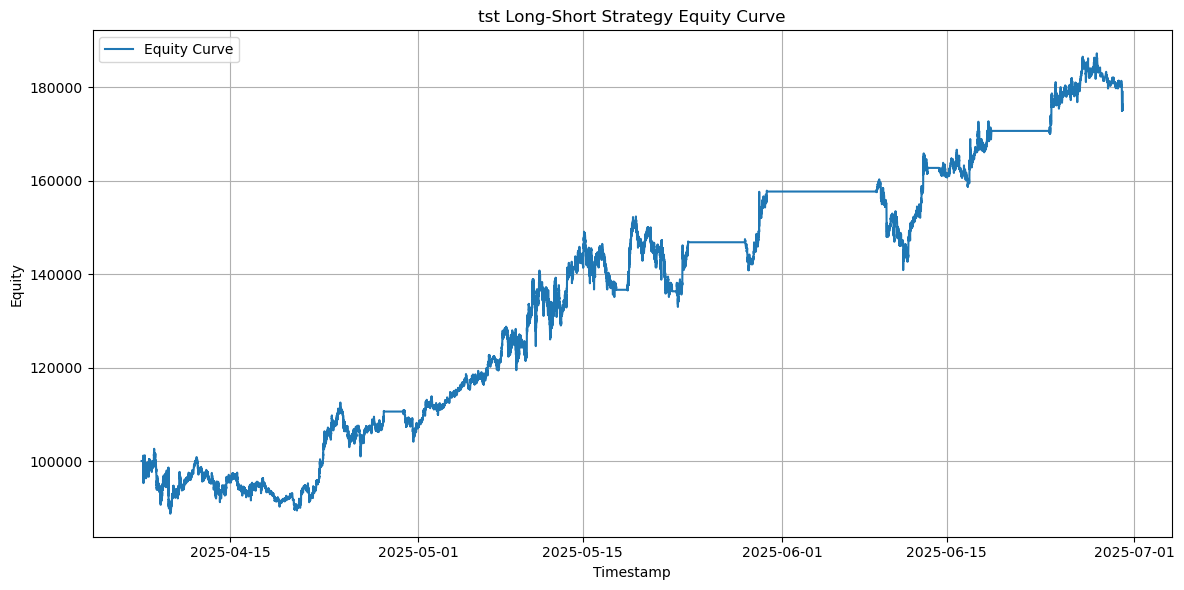

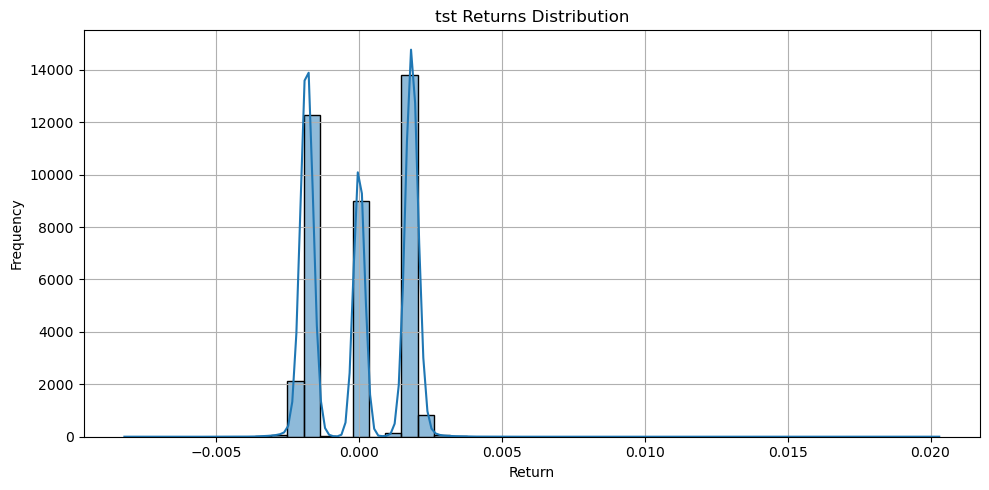

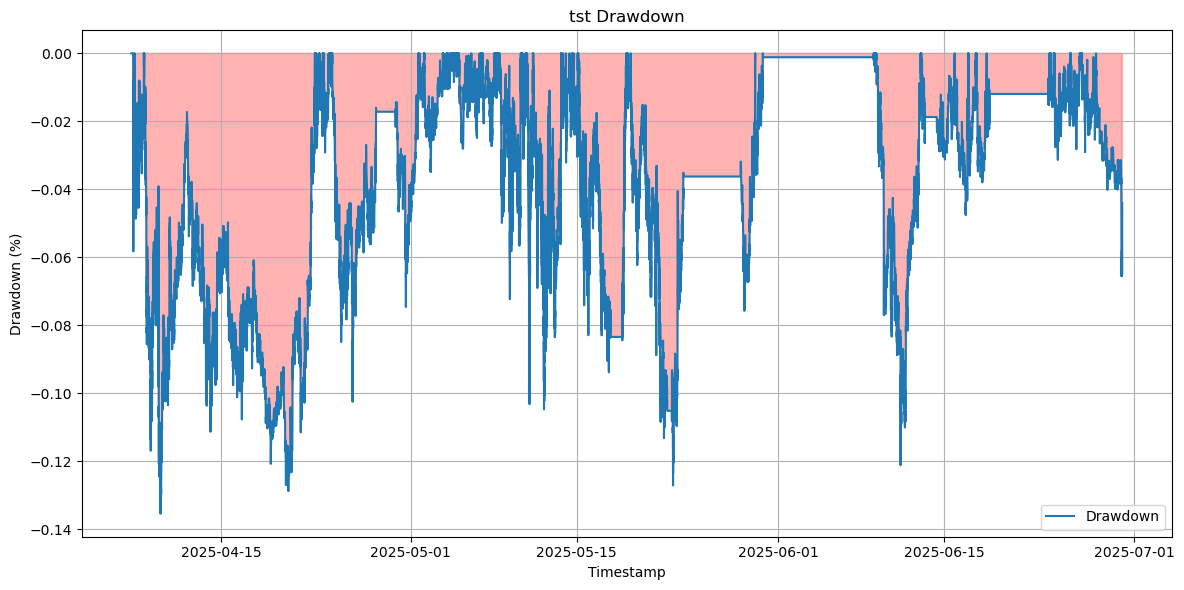

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

all_predictions_df = a_df.to_pandas()
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='ms') # Assuming microseconds


symbol_to_backtest = "tst"
df = all_predictions_df.copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.001   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.2 # Predicted probability above this to go long (buy)
short_threshold = -0.2 # Predicted probability below this to go short (sell)

beta = 5


# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []

for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df[feat].iloc[i]
    current_rolling_std = df['rolling_std'].iloc[i]

    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob < short_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            should_close = True
            reason = "Prediction below short threshold (close long)"
        if current_px <= sl_price:
            should_close = True
            reason = "Long Stop Loss Hit"
        elif current_px >= tp_price and predicted_prob < long_threshold:
            should_close = True
            reason = "Long Take Profit Hit"

        if should_close:
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob >= long_threshold: # Changed from buy_threshold to long_threshold
            should_close = True
            reason = "Prediction above long threshold (close short)"
        if current_px >= sl_price:
            should_close = True
            reason = "Short Stop Loss Hit"
        elif current_px <= tp_price and predicted_prob > short_threshold:
            should_close = True
            reason = "Short Take Profit Hit"

        if should_close:
            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df[feat].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df[feat].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()



Backtesting Results Summary (Long-Short Strategy):
Initial Capital: 100000.00
Final Capital: 49349.06
Total Return: -50.65%
Total Realized PnL: -49736.59
年化收益 (近似): -95.43%
Maximum Drawdown: -57.47%
Sharpe Ratio (Risk-Free Rate = 0): -282.81
Number of Trades: 74
Win Rate: 37.84%


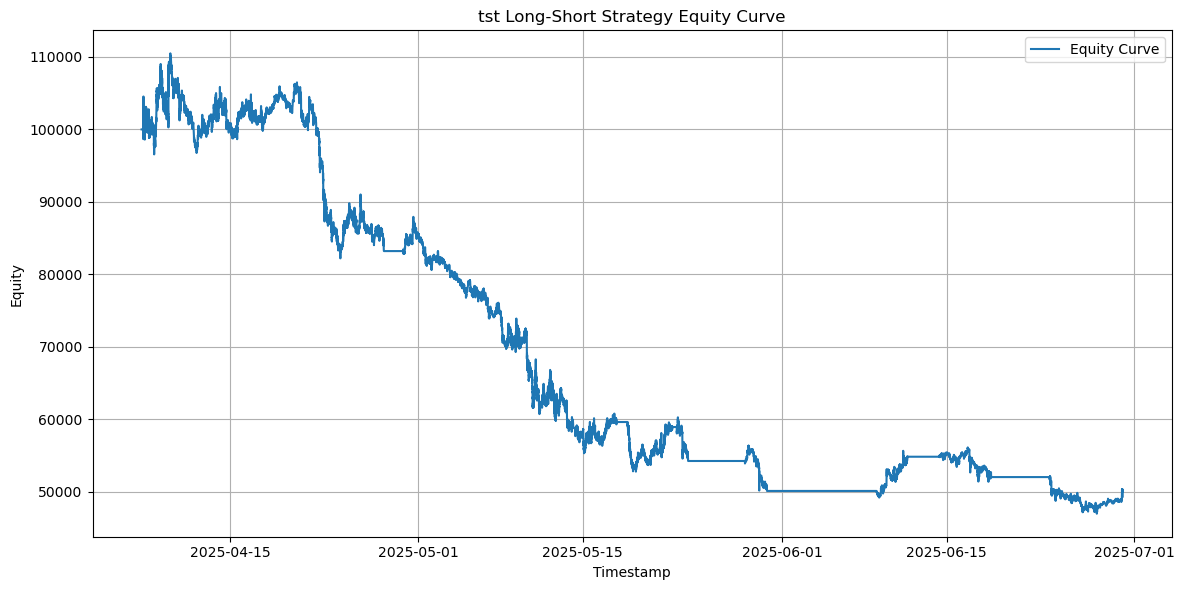

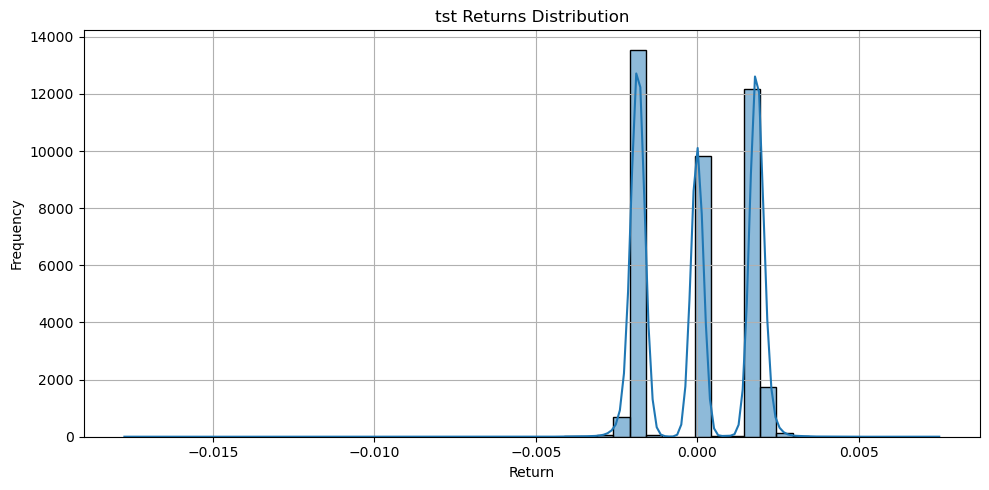

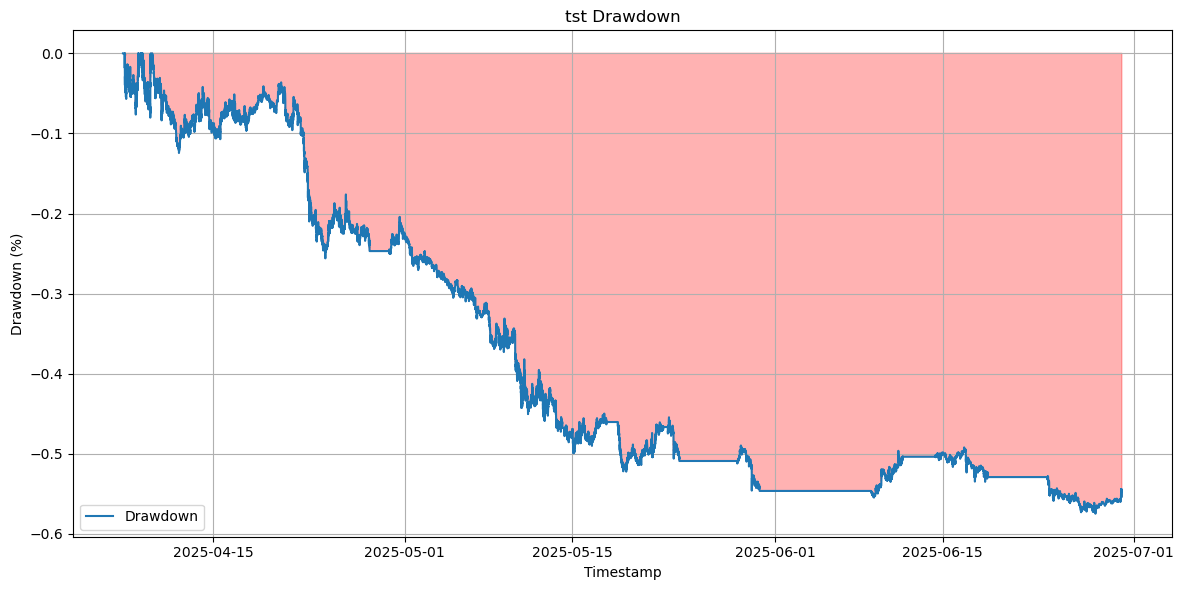

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

all_predictions_df = a_df.to_pandas()
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='ms') # Assuming microseconds


symbol_to_backtest = "tst"
df = all_predictions_df.copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.001   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.2 # Predicted probability above this to go long (buy)
short_threshold = -0.2 # Predicted probability below this to go short (sell)

beta = 5


# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []

for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df[feat].iloc[i]
    current_rolling_std = df['rolling_std'].iloc[i]

    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob <= short_threshold: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob >= long_threshold: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob >= long_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            should_close = True
            reason = "Prediction below short threshold (close long)"
        if current_px <= sl_price:
            should_close = True
            reason = "Long Stop Loss Hit"
        elif current_px >= tp_price and predicted_prob > short_threshold:
            should_close = True
            reason = "Long Take Profit Hit"

        if should_close:
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob <= short_threshold: # Changed from buy_threshold to long_threshold
            should_close = True
            reason = "Prediction above long threshold (close short)"
        if current_px >= sl_price:
            should_close = True
            reason = "Short Stop Loss Hit"
        elif current_px <= tp_price and predicted_prob < long_threshold:
            should_close = True
            reason = "Short Take Profit Hit"

        if should_close:
            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df[feat].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df[feat].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
38375    0.117831
38376    0.118516
38377    0.119189
38378    0.119853
38379    0.120525
Name: z_oi_down_divergence_momentum_ratio_10_zd_scaled, Length: 38380, dtype: float64


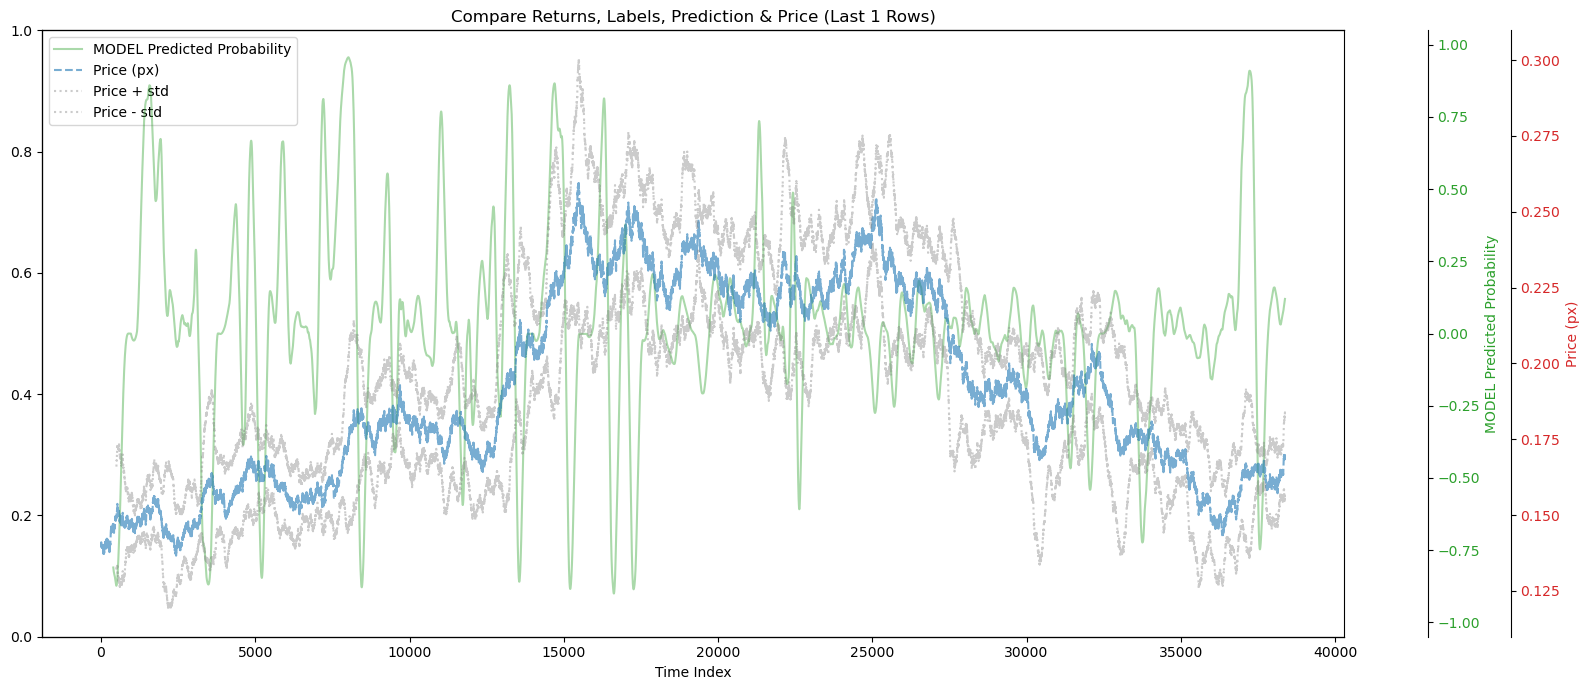

In [81]:
print(all_predictions_df[feat])
plot_last_n_rows_with_px(
    all_predictions_df[feat], 
    all_predictions_df[feat],      
    all_predictions_df[feat], 
    all_predictions_df['px'],
    std_array=all_predictions_df['rolling_std'],
    n=1,
    m=-1,
    alpha=beta,
)